## STEP 2: Data Pre-Processing

### Import necessary libraries

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### 2.1 Load datasets from file paths

In [5]:
data_path = '..\Dataset\data.csv'
genre_data_path = '..\Dataset\data_by_genres.csv'

# Check if files exist and load them
if os.path.exists(data_path) and os.path.exists(genre_data_path):
    data = pd.read_csv(data_path)
    genre_data = pd.read_csv(genre_data_path)
    print("Info: Data and genre data successfully loaded.")
else:
    print("Attention: One or both files are not found in the specified directory.")

Info: Data and genre data successfully loaded.


### 2.2 Descriptive statistics of features
This displays descriptive statistics for each dataset in a structured format.
Descriptive statistics (like mean, std, min, max, and quartiles) provide insights into data distributions.It helps in identifying central tendency, spread, and outliers across multiple datasets in one go.\
Explanation of descriptive statistics:
1. Count : The total number of non-missing entries for each feature.
2. Mean : The average value for each feature.
3. Std (Standard Deviation) : The spread or variability of the data around the mean.
4. Min : The minimum value in the dataset for each feature.
5. 25% (First Quartile) : The value below which 25% of the data falls.
6. 50% (Median) : The middle value, or the value below which 50% of the data falls.
7. 75% (Third Quartile) : The value below which 75% of the data falls.
8. Max : The maximum value in the dataset for each feature.

In [7]:
# Summary Statistics for numerical columns
num_data = data.select_dtypes(include=['float64', 'int64'])
data_desc = num_data.describe().transpose()

num_genredata = genre_data.select_dtypes(include=['float64', 'int64'])
genredata_desc = num_genredata.describe().transpose()

print("Summary Statistics for Data:")
display(data_desc)
print("\nSummary Statistics for Genre Data:")
display(genredata_desc)

# Unique Values for each column
data_unique_val = {col: data[col].nunique() for col in data.columns}
print("\nUnique Values in Each Column of Data:")
display(data_unique_val)

genredata_unique_val = {col: genre_data[col].nunique() for col in genre_data.columns}
print("\nUnique Values in Each Column of Genre data:")
display(genredata_unique_val)

Summary Statistics for Data:


,count,mean,std,min,25%,50%,75%,max
valence,170653.0,0.528587,0.263171,0.0,0.3170,0.540000,0.7470,1.000
year,170653.0,1976.787241,25.917853,1921.0,1956.0000,1977.000000,1999.0000,2020.000
acousticness,170653.0,0.502115,0.376032,0.0,0.1020,0.516000,0.8930,0.996
danceability,170653.0,0.537396,0.176138,0.0,0.4150,0.548000,0.6680,0.988
duration_ms,170653.0,230948.310666,126118.414668,5108.0,169827.0000,207467.000000,262400.0000,5403500.000
energy,170653.0,0.482389,0.267646,0.0,0.2550,0.471000,0.7030,1.000
explicit,170653.0,0.084575,0.278249,0.0,0.0000,0.000000,0.0000,1.000
instrumentalness,170653.0,0.167010,0.313475,0.0,0.0000,0.000216,0.1020,1.000
key,170653.0,5.199844,3.515094,0.0,2.0000,5.000000,8.0000,11.000
liveness,170653.0,0.205839,0.174805,0.0,0.0988,0.136000,0.2610,1.000



Summary Statistics for Genre Data:


,count,mean,std,min,25%,50%,75%,max
mode,2973.0,0.833165,0.372891,0.000000,1.000000,1.000000,1.000000,1.000000e+00
acousticness,2973.0,0.401241,0.319760,0.000003,0.119050,0.321745,0.673991,9.960000e-01
danceability,2973.0,0.537187,0.150668,0.056900,0.441202,0.546496,0.647500,9.290000e-01
duration_ms,2973.0,251720.854598,94656.856066,30946.000000,206378.846154,237545.336064,277272.000000,2.382587e+06
energy,2973.0,0.561143,0.234486,0.001002,0.395058,0.601195,0.730127,9.946667e-01
instrumentalness,2973.0,0.211366,0.267329,0.000000,0.004835,0.080700,0.343333,9.920000e-01
liveness,2973.0,0.192800,0.092356,0.022200,0.137687,0.178764,0.220856,9.600000e-01
loudness,2973.0,-10.509848,5.369202,-41.825000,-12.427656,-9.221817,-6.920125,6.000000e-02
speechiness,2973.0,0.083588,0.080483,0.023800,0.044900,0.059457,0.091000,9.462187e-01
tempo,2973.0,119.018723,17.469188,47.135722,109.198143,119.194167,127.508750,2.042120e+02



Unique Values in Each Column of Data:


{'valence': 1733,
 'year': 100,
 'acousticness': 4689,
 'artists': 34088,
 'danceability': 1240,
 'duration_ms': 51755,
 'energy': 2332,
 'explicit': 2,
 'id': 170653,
 'instrumentalness': 5401,
 'key': 12,
 'liveness': 1740,
 'loudness': 25410,
 'mode': 2,
 'name': 133638,
 'popularity': 100,
 'release_date': 11244,
 'speechiness': 1626,
 'tempo': 84694}


Unique Values in Each Column of Genre data:


{'mode': 2,
 'genres': 2973,
 'acousticness': 2798,
 'danceability': 2725,
 'duration_ms': 2872,
 'energy': 2778,
 'instrumentalness': 2731,
 'liveness': 2709,
 'loudness': 2873,
 'speechiness': 2707,
 'tempo': 2872,
 'valence': 2745,
 'popularity': 2188,
 'key': 12}

#### Conclusion for Descriptive statistics of Data
1. **Valence, Acousticness, Danceability, Energy:** These features exhibit a balanced distribution between 0 and 1, with means around 0.5. This indicates a diverse representation of musical characteristics, suggesting a wide variety of tracks in the dataset.

2. **Duration (ms):** Converting the duration from milliseconds to minutes will enhance the understanding of trends related to track length and its potential influence on other features.

3. **Instrumentalness:** The distribution of instrumentalness is left-skewed, with very few tracks exceeding a value of 0.5. This suggests that the dataset primarily consists of tracks with significant vocal presence, which is typical in most music collections.

4. **Speechiness:** The low mean value of approximately 0.10 indicates that most tracks are primarily musical rather than speech-heavy, supporting the expectation for a music recommendation system that focuses on songs rather than podcasts.

5. **Popularity:** With 75% of the tracks having a popularity score below 48, there is a notable scarcity of highly popular tracks. This highlights an opportunity for the recommendation system to explore and promote lesser-known but potentially valuable tracks.

6. **Year :** We have data samples from 1921 to 2020 in this dataset.

7. **loudness :**  The loudness feature ranges from -60.0 to 3.855, encompassing both positive and negative values. To facilitate better analysis and ensure that all features are on a similar scale, it would be beneficial to normalize this feature.

### 2.3 Visualizing Outliers in Numerical Variables with Boxplots

Outliers are data samples that falls on the far left or right side of the ordered data. Generally, the outliers fall more than the specified distance from the first and third quartile (IQR: Interquartile Range),(i.e.) outliers are greater than Q3 + (1.5 * IQR) or less than Q1 - (1.5 * IQR).

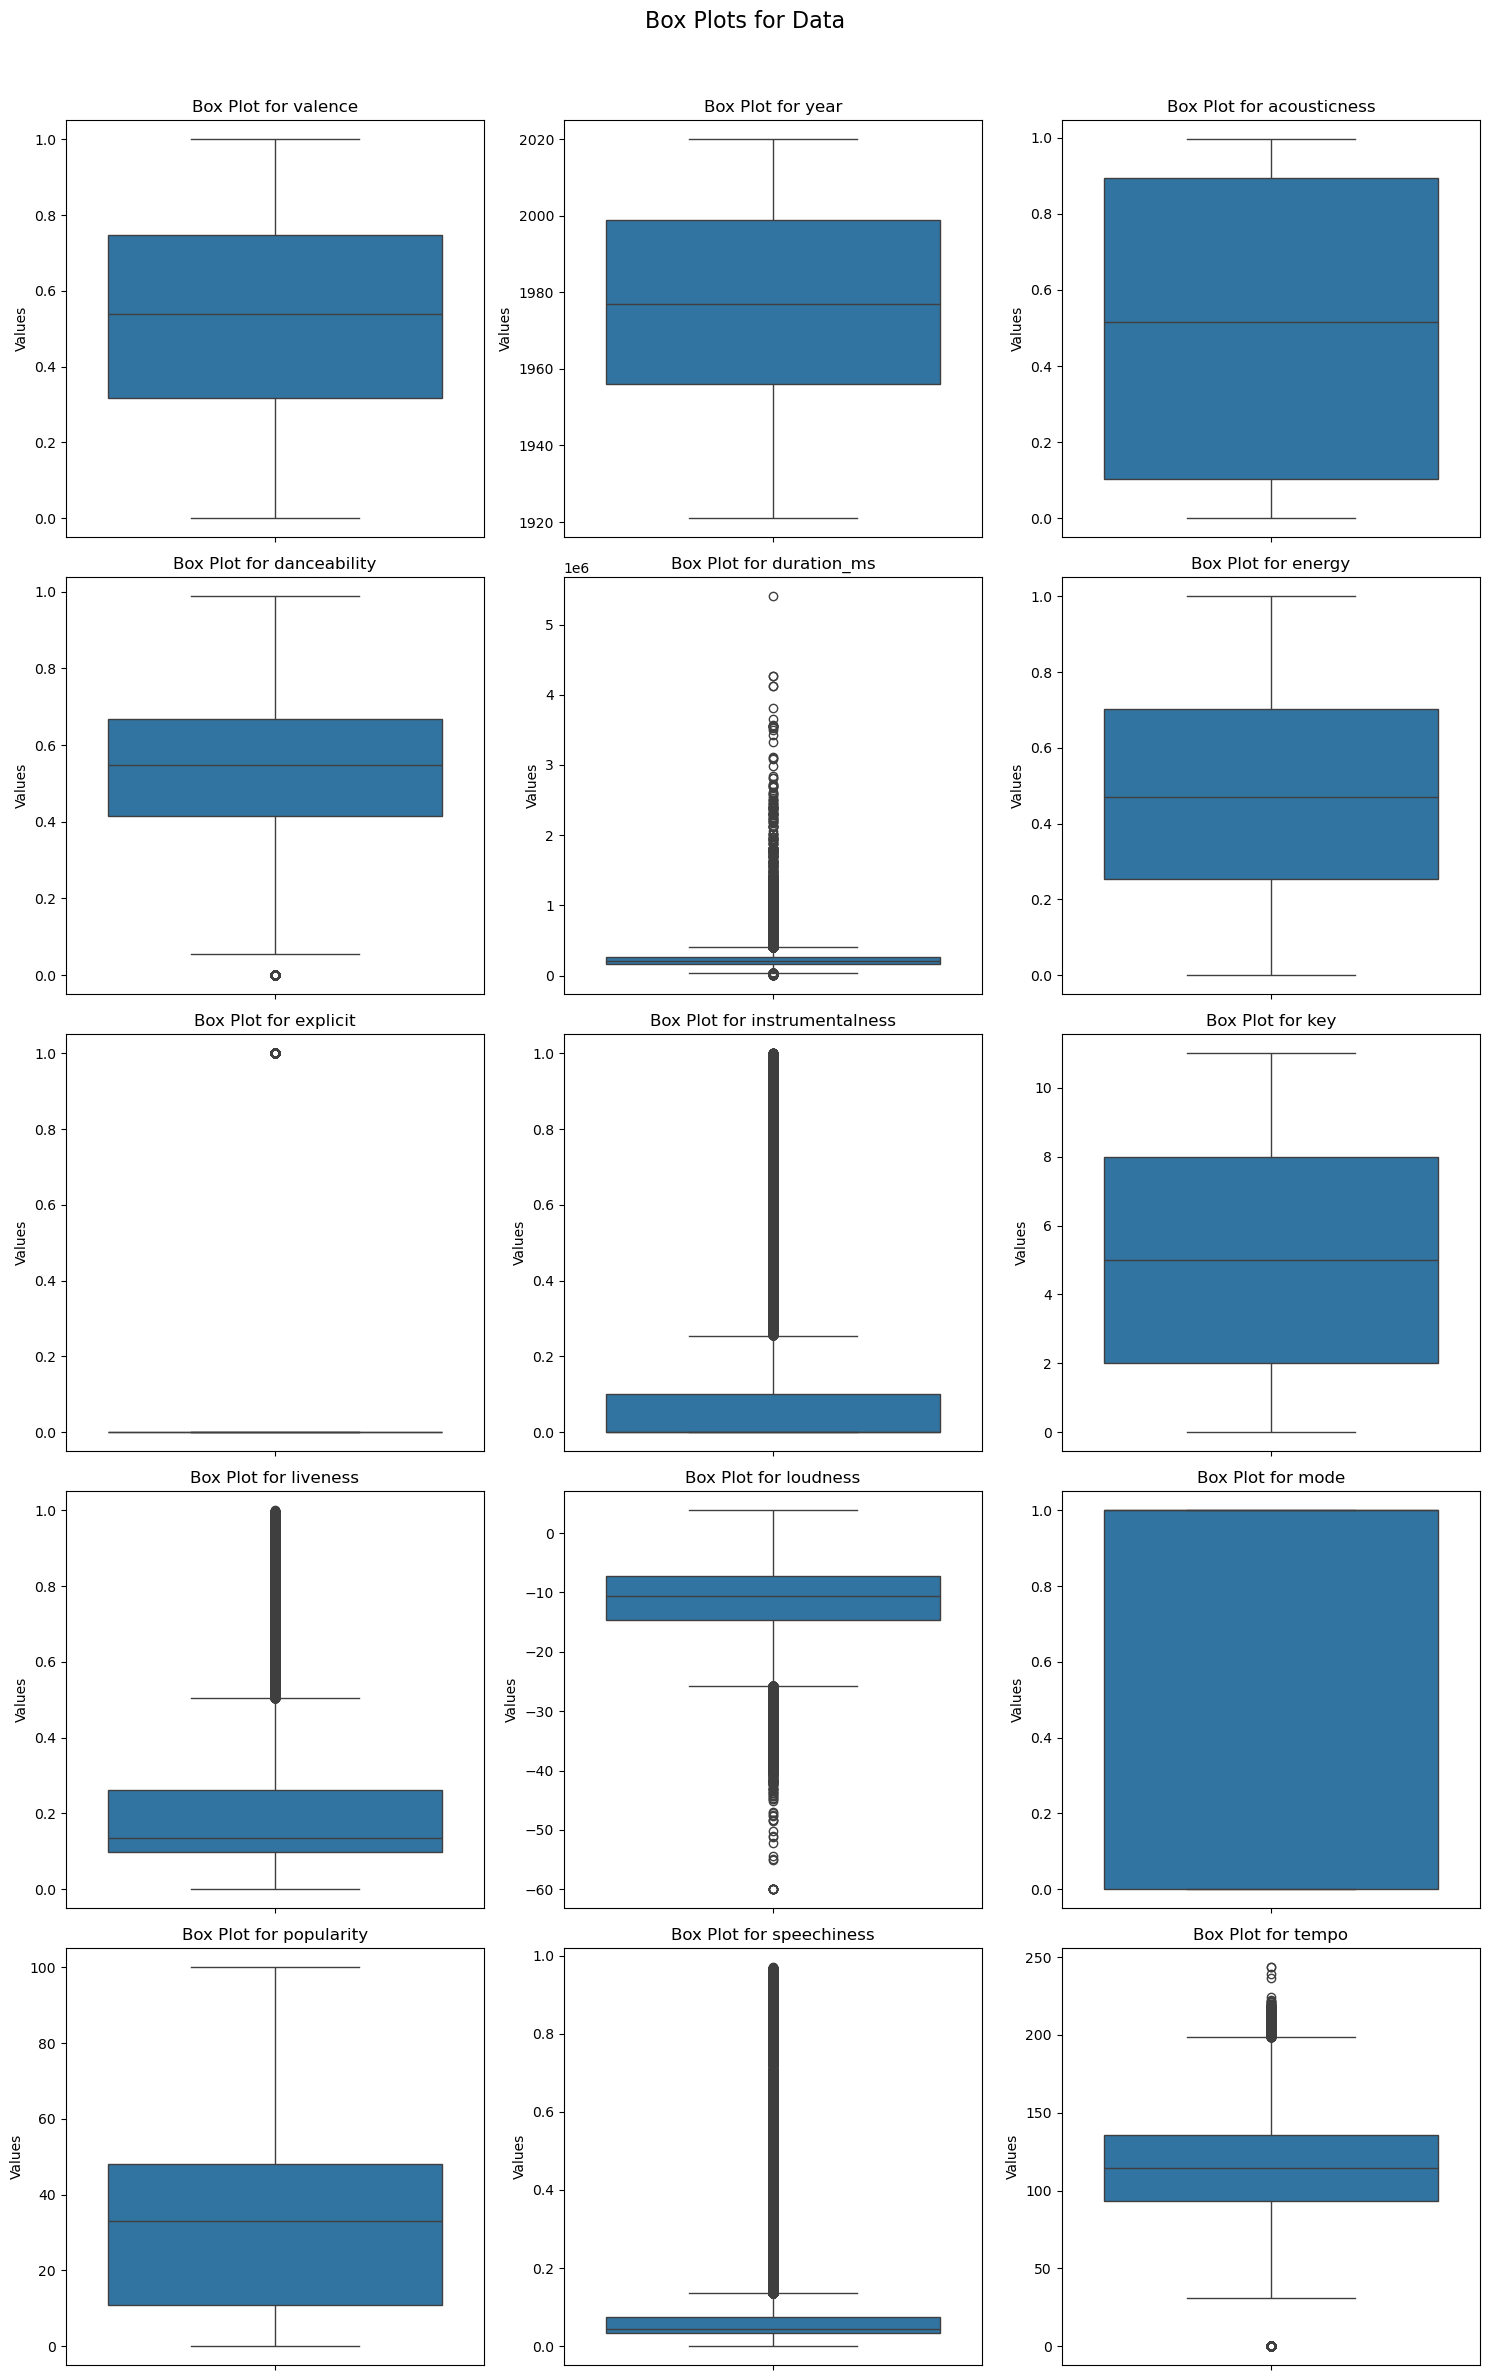

Outlier Summary for Data:
valence: 0 outliers
year: 0 outliers
acousticness: 0 outliers
danceability: 143 outliers
duration_ms: 9518 outliers
energy: 0 outliers
explicit: 14433 outliers
instrumentalness: 36105 outliers
key: 0 outliers
liveness: 11808 outliers
loudness: 3501 outliers
mode: 0 outliers
popularity: 0 outliers
speechiness: 23937 outliers
tempo: 1645 outliers


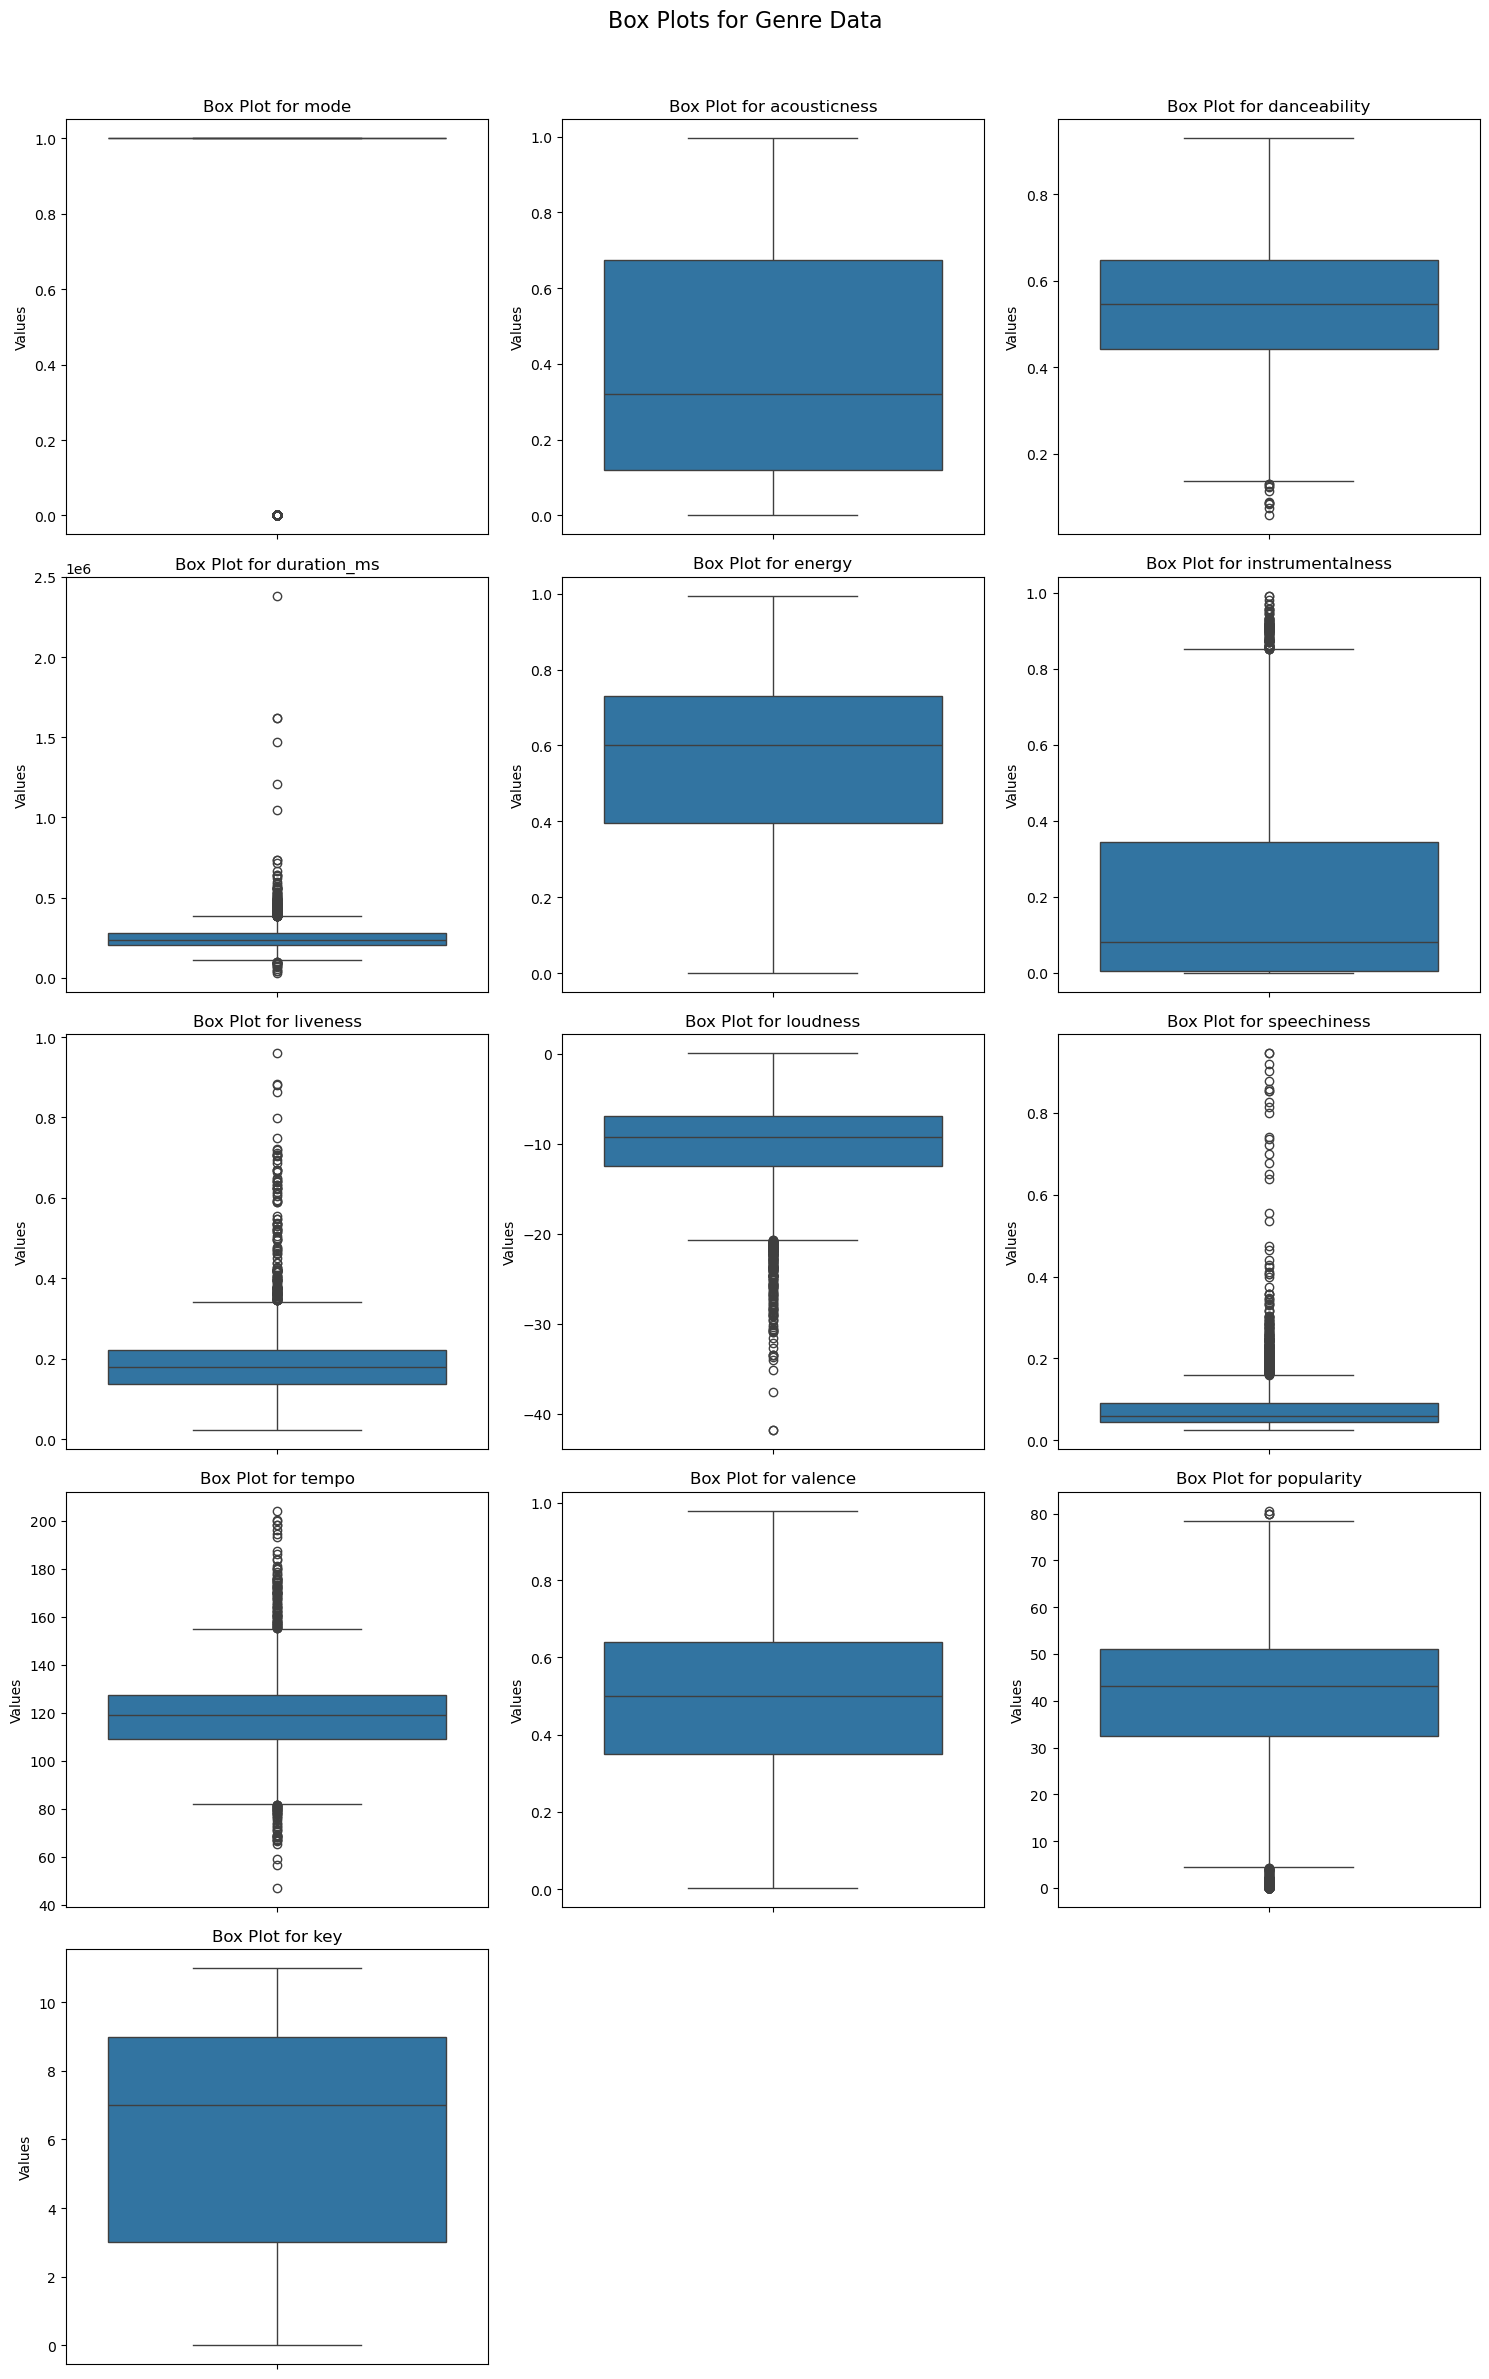

Outlier Summary for Genre Data:
mode: 496 outliers
acousticness: 0 outliers
danceability: 11 outliers
duration_ms: 153 outliers
energy: 0 outliers
instrumentalness: 117 outliers
liveness: 150 outliers
loudness: 198 outliers
speechiness: 265 outliers
tempo: 141 outliers
valence: 0 outliers
popularity: 196 outliers
key: 0 outliers


In [10]:
def plot_boxplots_with_outliers_summary(df, dataset_name):
    
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    num_cols = len(numerical_columns)
    rows = (num_cols // 3) + (num_cols % 3 > 0)  # Calculate number of rows needed for subplots
    outlier_counts = {}
    
    plt.figure(figsize=(15, rows * 5)) 
    
    for i, column in enumerate(numerical_columns):
        plt.subplot(rows, 3, i + 1)  
        sns.boxplot(y=df[column])
        plt.title(f'Box Plot for {column}')  
        plt.ylabel('Values')
        
        # Calculating IQR and identifying outliers
        Q1 = df[column].quantile(0.25)   # 25th precentile
        Q3 = df[column].quantile(0.75)   # 75th percentile
        IQR = Q3 - Q1      # length of the box (see box plot) IQR: Interquartile Range
        lower_bound = Q1 - 1.5 * IQR  # After this outliers are there (if any)
        upper_bound = Q3 + 1.5 * IQR   # After this outliers are there (if any)
        
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)] # To Find the outliers
        
        # Count outliers and add to the dictionary
        num_outliers = outliers.shape[0]
        outlier_counts[column] = num_outliers
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    plt.suptitle(f'Box Plots for {dataset_name}', fontsize=16, y=0.98)  
    plt.show()
    
    # SUMMARY
    print(f"Outlier Summary for {dataset_name}:")
    for column, count in outlier_counts.items():
        print(f"{column}: {count} outliers")


plot_boxplots_with_outliers_summary(data, 'Data')

plot_boxplots_with_outliers_summary(genre_data, 'Genre Data')

#### Conclusion from Boxplot Analysis of Outliers

- **duration_ms and tempo**: Songs with very high durations (like live performances) or unique tempos (extremely slow or fast) are often valid data points and may be retained depending on analysis needs.
- **instrumentalness, liveness and speechiness** : Given that this is a music recommendation system prioritizing vocal songs over live recordings or podcasts, it is expected that the dataset will show a greater concentration of values near 0 for instrumentalness, liveness, and speechiness. This aligns with the intention to recommend tracks that are primarily music-focused and feature significant vocal elements.
- **loudness**: Extremely low loudness values may represent specific song genres or recording qualities and may need further investigation to decide if they should be capped or retained.
- **explicit** : This is a categorical feature and it has only few data samples with explicit feature value as 1.However, it might help in personalised song recommendations.Hence, its better to retain this feature outliers.
- **danceability** : There are 143 outliers in Data and 11 outliers in Genre Data, with low danceability values.These outliers can be capped.

### 2.4 Outlier Handling

For outlier handling , Outlier Capping is chosen for its simplicity, effectiveness, and ability to retain data integrity. This method minimizes the impact of extreme values while preserving the dataset for accurate, interpretable analysis.

In [13]:
# Outliers capping for data and genre data

def cap_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)         # 25th percentile (first quartile)
        Q3 = df[column].quantile(0.75)         # 75th percentile (third quartile)
        IQR = Q3 - Q1                          # Interquartile Range (IQR)
        lower_bound = Q1 - 1.5 * IQR           # Lower limit for outliers
        upper_bound = Q3 + 1.5 * IQR           # Upper limit for outliers
        
        # Apply capping: replace values outside bounds with nearest boundary values
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Specify columns for outlier handling based on analysis
columns_to_cap_data = ['danceability']
columns_to_cap_genre = ['danceability']
                        
data_cleaned = cap_outliers(data.copy(), columns_to_cap_data)
genre_cleaned = cap_outliers(genre_data.copy(), columns_to_cap_genre)

# Display summary statistics of cleaned data
print('Data - Danceability column after cleaning')
display(data_cleaned[columns_to_cap_data].describe())

print('\n Genre Data - Danceability column after cleaning')
display(genre_cleaned[columns_to_cap_genre].describe())

Data - Danceability column after cleaning


,danceability
count,170653.000000
mean,0.537425
std,0.176050
min,0.035500
25%,0.415000
50%,0.548000
75%,0.668000
max,0.988000



 Genre Data - Danceability column after cleaning


,danceability
count,2973.000000
mean,0.537307
std,0.150324
min,0.131756
25%,0.441202
50%,0.546496
75%,0.647500
max,0.929000


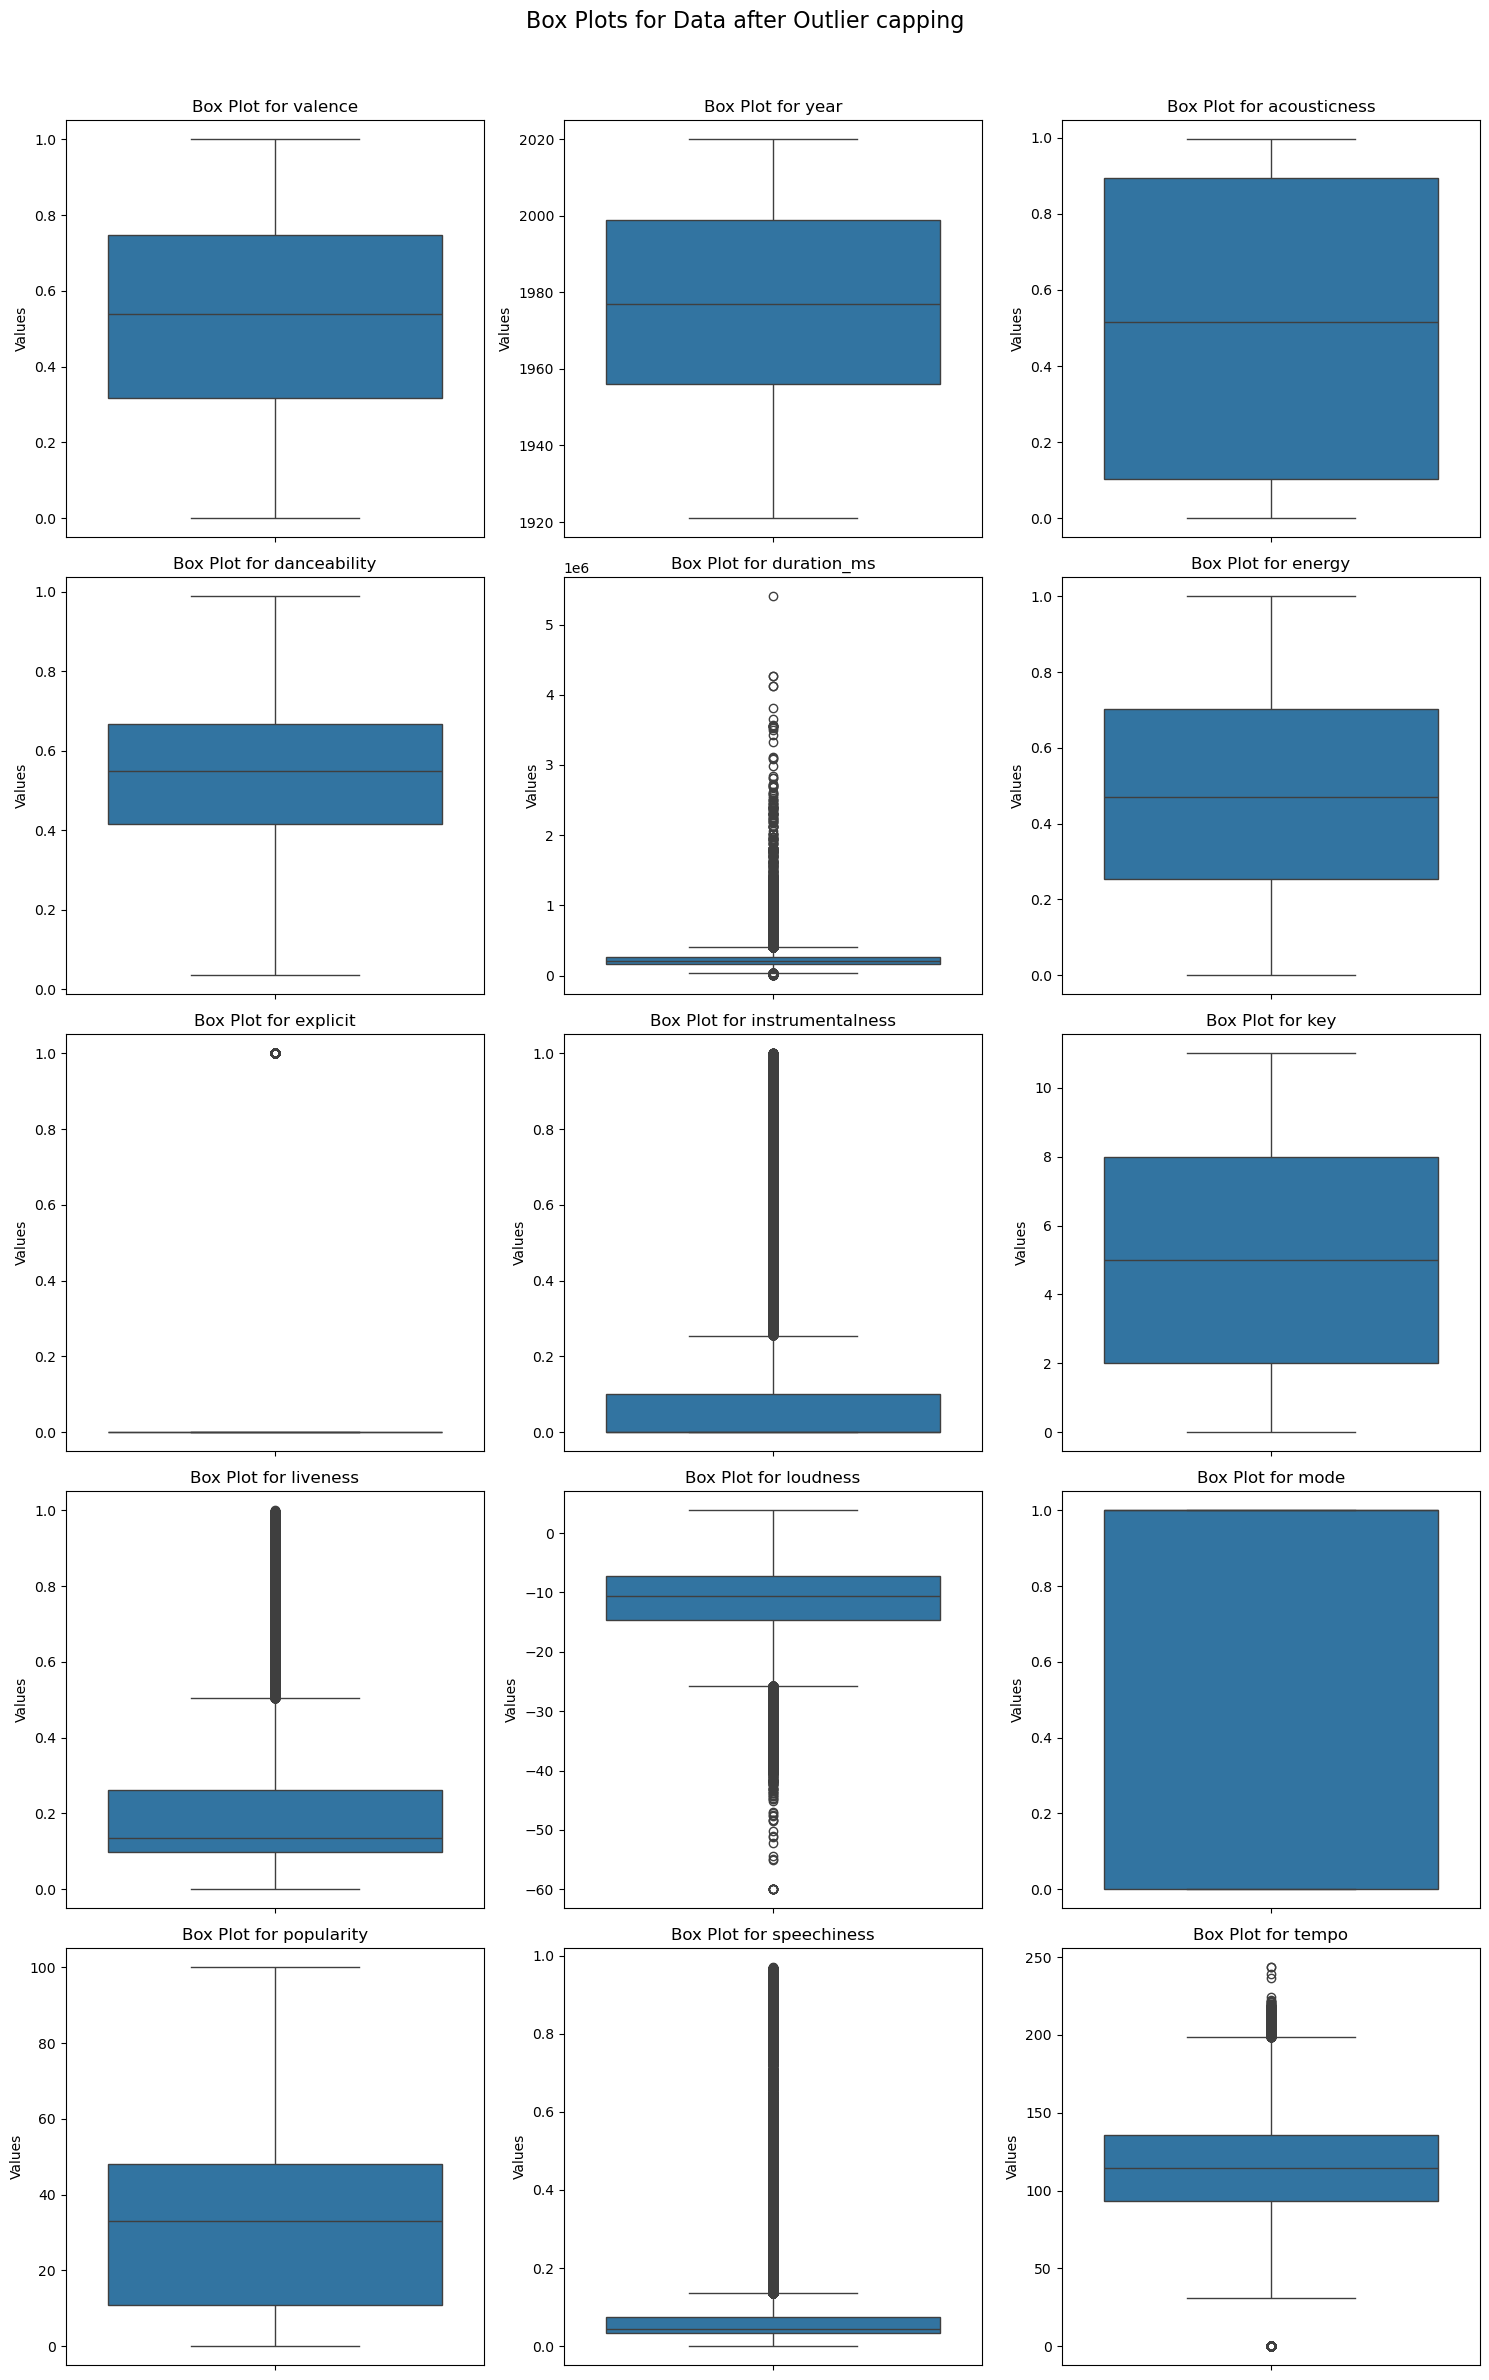

Outlier Summary for Data after Outlier capping:
valence: 0 outliers
year: 0 outliers
acousticness: 0 outliers
danceability: 0 outliers
duration_ms: 9518 outliers
energy: 0 outliers
explicit: 14433 outliers
instrumentalness: 36105 outliers
key: 0 outliers
liveness: 11808 outliers
loudness: 3501 outliers
mode: 0 outliers
popularity: 0 outliers
speechiness: 23937 outliers
tempo: 1645 outliers


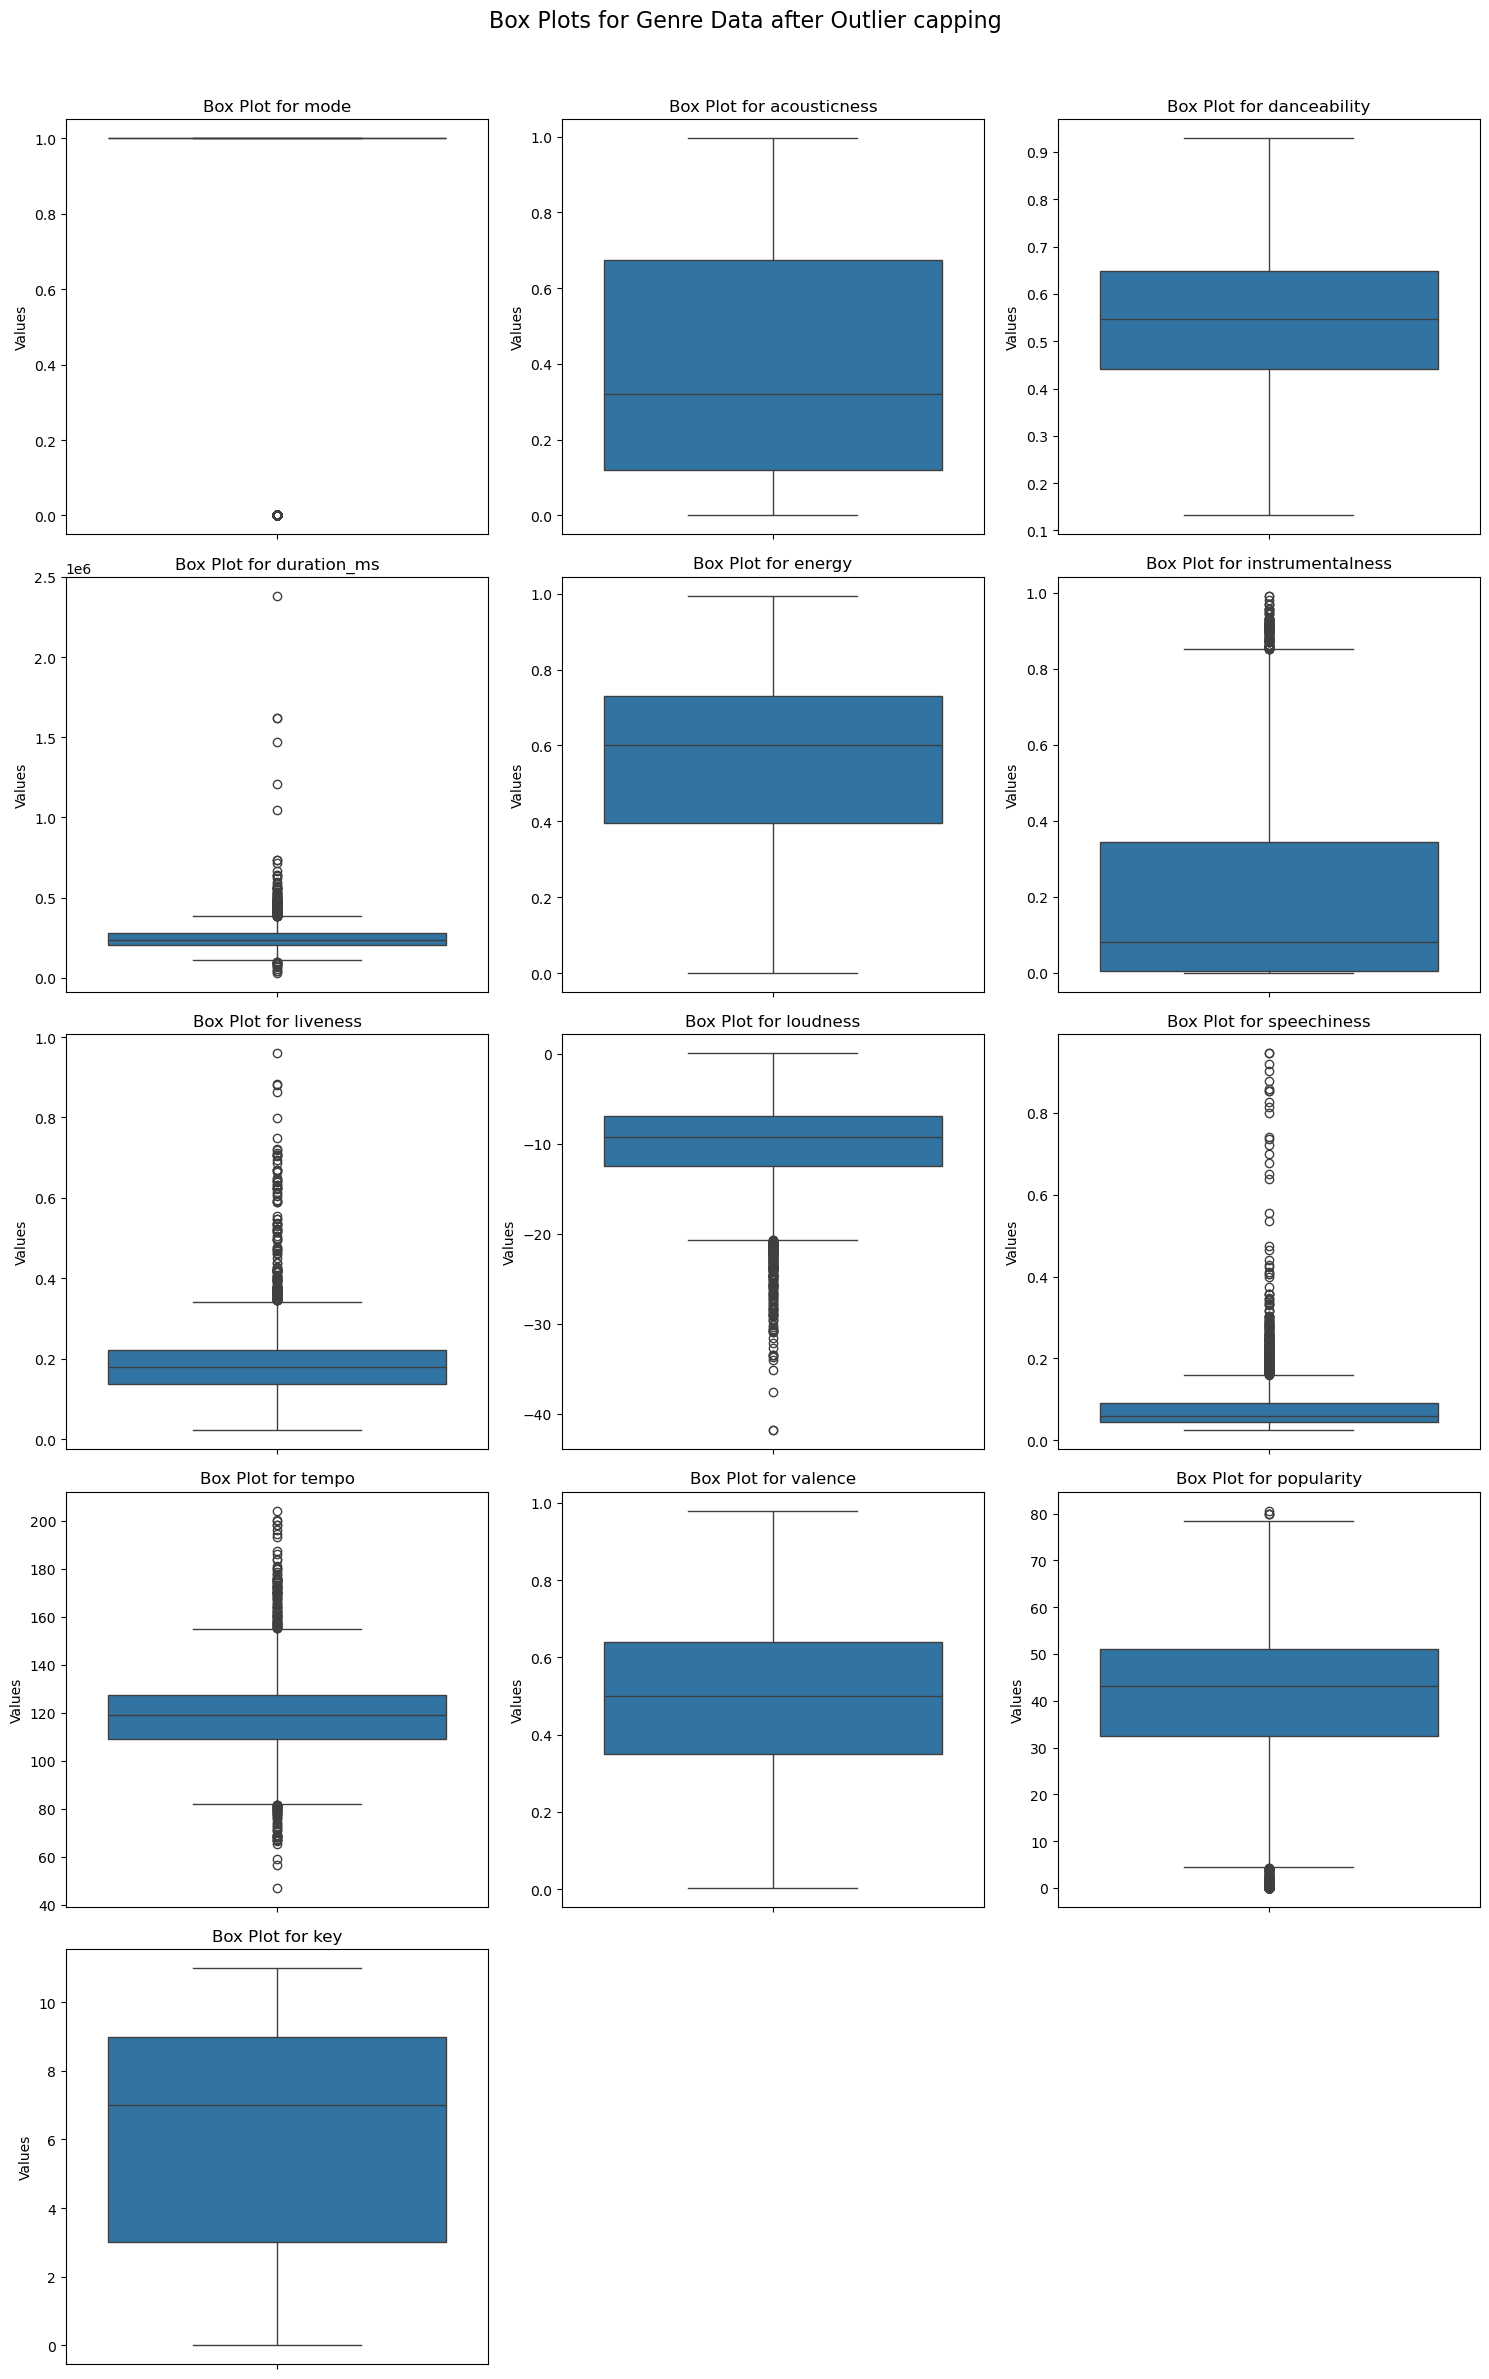

Outlier Summary for Genre Data after Outlier capping:
mode: 496 outliers
acousticness: 0 outliers
danceability: 0 outliers
duration_ms: 153 outliers
energy: 0 outliers
instrumentalness: 117 outliers
liveness: 150 outliers
loudness: 198 outliers
speechiness: 265 outliers
tempo: 141 outliers
valence: 0 outliers
popularity: 196 outliers
key: 0 outliers


In [14]:
#Plot the boxplots of all features after outlier capping

plot_boxplots_with_outliers_summary(data_cleaned, 'Data after Outlier capping')
plot_boxplots_with_outliers_summary(genre_cleaned, 'Genre Data after Outlier capping')

#### Conclusion from Outliers handling

- The column danceability had 143 outliers in Data and 11 outliers in Genre Data. After outlier capping , the column danceability has no outliers as plotted in above boxplot.
- All other features are retained with outliers , as they have too many outliers and they can provide important information for music recommendation system.

### 2.5 Feature Engineering

To enhance interpretability and enable more effective analysis, we can create new categorical features and transform existing ones. These engineered features will make it easier to identify trends and improve compatibility with models that benefit from normalized or categorical data.


#### 2.5.1 Add new music feature categorical columns

In [18]:
data_feature_stats = data.describe().loc[['min', '25%', '50%', '75%', 'max']]
genre_data_feature_stats = genre_data.describe().loc[['min', '25%', '50%', '75%', 'max']]

print('Important Data statistics')
display(data_feature_stats)

print('Important Genre Data statistics')
display(genre_data_feature_stats)

Important Data statistics


,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
min,0.000,1921.0,0.000,0.000,5108.0,0.000,0.0,0.000000,0.0,0.0000,-60.000,0.0,0.0,0.0000,0.000
25%,0.317,1956.0,0.102,0.415,169827.0,0.255,0.0,0.000000,2.0,0.0988,-14.615,0.0,11.0,0.0349,93.421
50%,0.540,1977.0,0.516,0.548,207467.0,0.471,0.0,0.000216,5.0,0.1360,-10.580,1.0,33.0,0.0450,114.729
75%,0.747,1999.0,0.893,0.668,262400.0,0.703,0.0,0.102000,8.0,0.2610,-7.183,1.0,48.0,0.0756,135.537
max,1.000,2020.0,0.996,0.988,5403500.0,1.000,1.0,1.000000,11.0,1.0000,3.855,1.0,100.0,0.9700,243.507


Important Genre Data statistics


,mode,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
min,0.0,0.000003,0.056900,3.094600e+04,0.001002,0.000000,0.022200,-41.825000,0.023800,47.135722,0.003353,0.000000,0.0
25%,1.0,0.119050,0.441202,2.063788e+05,0.395058,0.004835,0.137687,-12.427656,0.044900,109.198143,0.348578,32.491279,3.0
50%,1.0,0.321745,0.546496,2.375453e+05,0.601195,0.080700,0.178764,-9.221817,0.059457,119.194167,0.500048,43.056569,7.0
75%,1.0,0.673991,0.647500,2.772720e+05,0.730127,0.343333,0.220856,-6.920125,0.091000,127.508750,0.640257,51.138889,9.0
max,1.0,0.996000,0.929000,2.382587e+06,0.994667,0.992000,0.960000,0.060000,0.946219,204.212000,0.980000,80.666667,11.0


In [19]:
# Create interpretation matrix to convert audio features to categorical using thresholds

expanded_interpretation_matrix = {
    "Feature": [],
    "Range": [],
    "Description": [],
    "Data Stats": [],
    "Genre Data Stats": []
}

common_columns_stats = set(data.columns).intersection(set(genre_data.columns))

for column in common_columns_stats:
    for range_stat in ['min', '25%', '50%', '75%', 'max']:
        expanded_interpretation_matrix["Feature"].append(column)
        expanded_interpretation_matrix["Range"].append(range_stat)
        
        # Set interpretation based on each feature's meaning in the music industry
        if column == "valence":
            description = {
                'min': "Very Low - emotionally negative or neutral",
                '25%': "Low - somewhat negative or subdued emotion",
                '50%': "Moderate - balanced or neutral emotion",
                '75%': "High - positive and bright emotion",
                'max': "Very High - highly positive and happy"
            }
        elif column == "acousticness":
            description = {
                'min': "No acoustic elements, entirely synthetic or electronic",
                '25%': "Low acoustic presence, minor acoustic components",
                '50%': "Moderate acoustic presence, some mix of electronic and acoustic sounds",
                '75%': "High acoustic presence, mainly acoustic",
                'max': "Extremely acoustic, almost entirely devoid of electronic elements"
            }
        elif column == "danceability":
            description = {
                'min': "Very low danceability, not suited for dancing",
                '25%': "Low danceability, limited rhythmic appeal",
                '50%': "Moderate danceability, suitable for light dancing",
                '75%': "High danceability, good rhythmic appeal",
                'max': "Very high danceability, very rhythmic and suited for dancing"
            }
        elif column == "energy":
            description = {
                'min': "Very low energy, calm or subdued",
                '25%': "Low energy, relaxed or mellow",
                '50%': "Moderate energy, balanced intensity",
                '75%': "High energy, lively or intense",
                'max': "Very high energy, intense and energetic"
            }
        elif column == "liveness":
            description = {
                'min': "Very low, studio recording with no live elements",
                '25%': "Low live presence, possibly slight live recording",
                '50%': "Moderate live presence, hints of live performance",
                '75%': "High live presence, strong live recording elements",
                'max': "Very high, complete live recording or concert setting"
            }
        elif column == "instrumentalness":
            description = {
                'min': "No instrumental elements, entirely vocal",
                '25%': "Low instrumental presence, primarily vocal with some instrumental",
                '50%': "Moderate instrumental presence, significant instrumental parts",
                '75%': "High instrumental presence, mostly instrumental",
                'max': "Very high instrumental presence, entirely instrumental"
            }
        elif column == "speechiness":
            description = {
                'min': "Very low, mainly musical sounds",
                '25%': "Low presence of spoken words",
                '50%': "Moderate speech, balanced with music",
                '75%': "High speech, primarily vocal-driven",
                'max': "Very high, mainly spoken words or narration"
            }
        elif column == "tempo":
            description = {
                'min': "Very slow, potentially ambient or background music",
                '25%': "Slow tempo, relaxing and unhurried",
                '50%': "Moderate tempo, typical for pop and rock",
                '75%': "Fast tempo, upbeat and energetic",
                'max': "Very fast, high-energy music such as EDM"
            }
        elif column == "loudness":
            description = {
                'min': "Very quiet, often ambient or background sound",
                '25%': "Low loudness, soft or subdued sound",
                '50%': "Moderate loudness, typical for most music",
                '75%': "High loudness, strong sound presence",
                'max': "Very loud, intense and full-bodied sound"
            }
        elif column == "popularity":
            description = {
                'min': "Very low popularity, niche or little-known",
                '25%': "Low popularity, limited audience",
                '50%': "Moderately popular, some audience reach",
                '75%': "High popularity, well-liked and familiar",
                'max': "Very high popularity, widely known and favored"
            }
        elif column == "key":
            description = {
                'min': "Very low, typically quieter tonal center",
                '25%': "Low, less common tonal center",
                '50%': "Moderate, standard tonal center",
                '75%': "High, popular tonal centers like G or A",
                'max': "Very high, uncommon tonal centers"
            }
        elif column =="duration_ms":
            description = {
                'min': "Very short duration, often intros or interludes",
                '25%': "Short duration, typically for radio or pop songs",
                '50%': "Moderate duration, standard length for most songs",
                '75%': "Long duration, typical for extended versions or certain genres",
                'max': "Very long duration, usually instrumental or progressive pieces"
            }

        else:
            description = {stat: f"Interpretation for {column} at {stat}" for stat in ['min', '25%', '50%', '75%', 'max']}

        expanded_interpretation_matrix["Description"].append(description[range_stat])
        expanded_interpretation_matrix["Data Stats"].append(data_feature_stats.loc[range_stat, column])
        expanded_interpretation_matrix["Genre Data Stats"].append(genre_data_feature_stats.loc[range_stat, column])

expanded_interpretation_matrix_df = pd.DataFrame(expanded_interpretation_matrix)

display(expanded_interpretation_matrix_df)

,Feature,Range,Description,Data Stats,Genre Data Stats
0,energy,min,"Very low energy, calm or subdued",0.000,0.001002
1,energy,25%,"Low energy, relaxed or mellow",0.255,0.395058
2,energy,50%,"Moderate energy, balanced intensity",0.471,0.601195
3,energy,75%,"High energy, lively or intense",0.703,0.730127
4,energy,max,"Very high energy, intense and energetic",1.000,0.994667
...,...,...,...,...,...
60,loudness,min,"Very quiet, often ambient or background sound",-60.000,-41.825000
61,loudness,25%,"Low loudness, soft or subdued sound",-14.615,-12.427656
62,loudness,50%,"Moderate loudness, typical for most music",-10.580,-9.221817
63,loudness,75%,"High loudness, strong sound presence",-7.183,-6.920125


In [20]:
# DICTIONARY
category_thresholds = {
    "valence": [data_feature_stats["valence"]["min"], data_feature_stats["valence"]["25%"],
                data_feature_stats["valence"]["50%"], data_feature_stats["valence"]["75%"], data_feature_stats["valence"]["max"]],
    "acousticness": [data_feature_stats["acousticness"]["min"], data_feature_stats["acousticness"]["25%"],
                     data_feature_stats["acousticness"]["50%"], data_feature_stats["acousticness"]["75%"], data_feature_stats["acousticness"]["max"]],
    "danceability": [data_feature_stats["danceability"]["min"], data_feature_stats["danceability"]["25%"],
                     data_feature_stats["danceability"]["50%"], data_feature_stats["danceability"]["75%"], data_feature_stats["danceability"]["max"]],
    "energy": [data_feature_stats["energy"]["min"], data_feature_stats["energy"]["25%"],
               data_feature_stats["energy"]["50%"], data_feature_stats["energy"]["75%"], data_feature_stats["energy"]["max"]],
    "liveness": [data_feature_stats["liveness"]["min"], data_feature_stats["liveness"]["25%"],
                 data_feature_stats["liveness"]["50%"], data_feature_stats["liveness"]["75%"], data_feature_stats["liveness"]["max"]],
    "instrumentalness": [data_feature_stats["instrumentalness"]["min"], data_feature_stats["instrumentalness"]["25%"],
                         data_feature_stats["instrumentalness"]["50%"], data_feature_stats["instrumentalness"]["75%"], data_feature_stats["instrumentalness"]["max"]],
    "speechiness": [data_feature_stats["speechiness"]["min"], data_feature_stats["speechiness"]["25%"],
                    data_feature_stats["speechiness"]["50%"], data_feature_stats["speechiness"]["75%"], data_feature_stats["speechiness"]["max"]],
    "tempo": [data_feature_stats["tempo"]["min"], data_feature_stats["tempo"]["25%"],
              data_feature_stats["tempo"]["50%"], data_feature_stats["tempo"]["75%"], data_feature_stats["tempo"]["max"]],
    "loudness": [data_feature_stats["loudness"]["min"], data_feature_stats["loudness"]["25%"],
                 data_feature_stats["loudness"]["50%"], data_feature_stats["loudness"]["75%"], data_feature_stats["loudness"]["max"]],
    "popularity": [data_feature_stats["popularity"]["min"], data_feature_stats["popularity"]["25%"],
                   data_feature_stats["popularity"]["50%"], data_feature_stats["popularity"]["75%"], data_feature_stats["popularity"]["max"]],
    "key": [data_feature_stats["key"]["min"], data_feature_stats["key"]["25%"],
            data_feature_stats["key"]["50%"], data_feature_stats["key"]["75%"], data_feature_stats["key"]["max"]],
    "duration_ms": [data_feature_stats["duration_ms"]["min"], data_feature_stats["duration_ms"]["25%"],
                    data_feature_stats["duration_ms"]["50%"], data_feature_stats["duration_ms"]["75%"], data_feature_stats["duration_ms"]["max"]]
}

def categorize_feature(value, thresholds, descriptions):
    if value <= thresholds[1]:
        return descriptions[0]             # Min description
    elif value <= thresholds[2]:
        return descriptions[1]             # 25% description
    elif value <= thresholds[3]:
        return descriptions[2]             # 50% description
    elif value <= thresholds[4]:
        return descriptions[3]             # 75% description
    else:
        return descriptions[4]             # Max description

for feature, thresholds in category_thresholds.items():
    
    # Retrieve descriptions for this feature from the interpretation matrix
    descriptions = expanded_interpretation_matrix_df[expanded_interpretation_matrix_df["Feature"] == feature]["Description"].values
    
    # Apply categorization based on thresholds
    data[f"{feature}_category"] = data[feature].apply(lambda x: categorize_feature(x, thresholds, descriptions))
    genre_data[f"{feature}_category"] = genre_data[feature].apply(lambda x: categorize_feature(x, thresholds, descriptions))


print("Data after adding new audio features categorical columns")
display(data.head())

print("Genre Data after adding new audio features categorical column")
display(genre_data.head())


Data after adding new audio features categorical columns


,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,danceability_category,energy_category,liveness_category,instrumentalness_category,speechiness_category,tempo_category,loudness_category,popularity_category,key_category,duration_ms_category
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,...,"Very low danceability, not suited for dancing","Very low energy, calm or subdued","High live presence, strong live recording elem...","High instrumental presence, mostly instrumental",Low presence of spoken words,"Very slow, potentially ambient or background m...","Very quiet, often ambient or background sound","Very low popularity, niche or little-known","High, popular tonal centers like G or A","Long duration, typical for extended versions o..."
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,"High danceability, good rhythmic appeal","Low energy, relaxed or mellow","Moderate live presence, hints of live performance","No instrumental elements, entirely vocal","High speech, primarily vocal-driven","Very slow, potentially ambient or background m...","Low loudness, soft or subdued sound","Very low popularity, niche or little-known","Moderate, standard tonal center","Short duration, typically for radio or pop songs"
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,"Very low danceability, not suited for dancing","Very low energy, calm or subdued","Low live presence, possibly slight live recording","High instrumental presence, mostly instrumental","Very low, mainly musical sounds","Slow tempo, relaxing and unhurried","Very quiet, often ambient or background sound","Very low popularity, niche or little-known","Low, less common tonal center","Long duration, typical for extended versions o..."
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,"Very low danceability, not suited for dancing","Low energy, relaxed or mellow","High live presence, strong live recording elem...","Low instrumental presence, primarily vocal wit...",Low presence of spoken words,"Slow tempo, relaxing and unhurried","Moderate loudness, typical for most music","Very low popularity, niche or little-known","Low, less common tonal center","Moderate duration, standard length for most songs"
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,"Low danceability, limited rhythmic appeal","Very low energy, calm or subdued","Moderate live presence, hints of live performance","Low instrumental presence, primarily vocal wit...",Low presence of spoken words,"Slow tempo, relaxing and unhurried","Moderate loudness, typical for most music","Very low popularity, niche or little-known","Low, less common tonal center","Very short duration, often intros or interludes"


Genre Data after adding new audio features categorical column


,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,...,danceability_category,energy_category,liveness_category,instrumentalness_category,speechiness_category,tempo_category,loudness_category,popularity_category,key_category,duration_ms_category
0,1,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.361600,-31.514333,0.040567,...,"Very low danceability, not suited for dancing","Very low energy, calm or subdued","High live presence, strong live recording elem...","High instrumental presence, mostly instrumental",Low presence of spoken words,"Very slow, potentially ambient or background m...","Very quiet, often ambient or background sound","Low popularity, limited audience","Moderate, standard tonal center","Very short duration, often intros or interludes"
1,1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,...,"Very low danceability, not suited for dancing","Low energy, relaxed or mellow","Low live presence, possibly slight live recording","High instrumental presence, mostly instrumental","High speech, primarily vocal-driven","Moderate tempo, typical for pop and rock","Very quiet, often ambient or background sound","High popularity, well-liked and familiar","Low, less common tonal center","Long duration, typical for extended versions o..."
2,1,8-bit,0.762000,0.712000,1.151770e+05,0.818000,0.876000,0.126000,-9.180000,0.047000,...,"High danceability, good rhythmic appeal","High energy, lively or intense","Low live presence, possibly slight live recording","High instrumental presence, mostly instrumental","Moderate speech, balanced with music","Moderate tempo, typical for pop and rock","Moderate loudness, typical for most music","Moderately popular, some audience reach","Moderate, standard tonal center","Very short duration, often intros or interludes"
3,1,[],0.651417,0.529093,2.328809e+05,0.419146,0.205309,0.218696,-12.288965,0.107872,...,"Low danceability, limited rhythmic appeal","Low energy, relaxed or mellow","Moderate live presence, hints of live performance","High instrumental presence, mostly instrumental","High speech, primarily vocal-driven","Slow tempo, relaxing and unhurried","Low loudness, soft or subdued sound","Low popularity, limited audience","Moderate, standard tonal center","Moderate duration, standard length for most songs"
4,1,a cappella,0.676557,0.538961,1.906285e+05,0.316434,0.003003,0.172254,-12.479387,0.082851,...,"Low danceability, limited rhythmic appeal","Low energy, relaxed or mellow","Moderate live presence, hints of live performance","Moderate instrumental presence, significant in...","High speech, primarily vocal-driven","Slow tempo, relaxing and unhurried","Low loudness, soft or subdued sound","Moderately popular, some audience reach","Moderate, standard tonal center","Short duration, typically for radio or pop songs"


##### Conclusion

- Columns'valence_category', 'acousticness_category', 'danceability_category','energy_category', 'liveness_category', 'instrumentalness_category','speechiness_category', 'tempo_category', 'loudness_category','popularity_category', 'key_category', 'duration_ms_category' have been added to provide a clearer understanding of the numerical values, based on their relative positions within the overall range (e.g., less than 25%, 50%, 75%, or 100%).

#### 2.5.2 Convert/Normalize existing columns

In [23]:
# Convert duration from milliseconds to minutes and discarding duration_ms column
data['duration_min'] = round(data['duration_ms'] / 60000)
data = data.drop(columns=['duration_ms'])

genre_data['duration_min'] = round(genre_data['duration_ms'] / 60000)
genre_data = genre_data.drop(columns=['duration_ms'])

# Add column loudness_Scaled with normalized loudness
data['loudness_scaled'] = (data['loudness'] - data['loudness'].min()) / (data['loudness'].max() - data['loudness'].min())
data = data.drop(columns=['loudness'])

genre_data['loudness_scaled'] = (genre_data['loudness'] - genre_data['loudness'].min()) / (genre_data['loudness'].max() - genre_data['loudness'].min())
genre_data = genre_data.drop(columns=['loudness'])

# Extract the release decade from the year
data['release_decade'] = (data['year'] // 10) * 10

# Add column 'mode_category' using mode 
data['mode_category'] = data['mode'].map({0: 'Low, often minor scale (sadder tone)', 1: 'High, often major scale (happier tone)'})
genre_data['mode_category'] = genre_data['mode'].map({0: 'Low, often minor scale (sadder tone)', 1: 'High, often major scale (happier tone)'})

# Add column 'explicit_category' using explicit 
data['explicit_category'] = np.where(data['explicit'] == 1, 'Yes', 'No')

print("Data after adding new columns")
display(data.head())

print("Genre Data after adding new columns")
display(genre_data.head())

Data after adding new columns


,valence,year,acousticness,artists,danceability,energy,explicit,id,instrumentalness,key,...,tempo_category,loudness_category,popularity_category,key_category,duration_ms_category,duration_min,loudness_scaled,release_decade,mode_category,explicit_category
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,...,"Very slow, potentially ambient or background m...","Very quiet, often ambient or background sound","Very low popularity, niche or little-known","High, popular tonal centers like G or A","Long duration, typical for extended versions o...",14.0,0.624916,1920,"High, often major scale (happier tone)",No
1,0.9630,1921,0.732,['Dennis Day'],0.819,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,...,"Very slow, potentially ambient or background m...","Low loudness, soft or subdued sound","Very low popularity, niche or little-known","Moderate, standard tonal center","Short duration, typically for radio or pop songs",3.0,0.744797,1920,"High, often major scale (happier tone)",No
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,...,"Slow tempo, relaxing and unhurried","Very quiet, often ambient or background sound","Very low popularity, niche or little-known","Low, less common tonal center","Long duration, typical for extended versions o...",8.0,0.707071,1920,"High, often major scale (happier tone)",No
3,0.1650,1921,0.967,['Frank Parker'],0.275,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,...,"Slow tempo, relaxing and unhurried","Moderate loudness, typical for most music","Very low popularity, niche or little-known","Low, less common tonal center","Moderate duration, standard length for most songs",4.0,0.793736,1920,"High, often major scale (happier tone)",No
4,0.2530,1921,0.957,['Phil Regan'],0.418,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,...,"Slow tempo, relaxing and unhurried","Moderate loudness, typical for most music","Very low popularity, niche or little-known","Low, less common tonal center","Very short duration, often intros or interludes",3.0,0.781521,1920,"High, often major scale (happier tone)",No


Genre Data after adding new columns


,mode,genres,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,...,instrumentalness_category,speechiness_category,tempo_category,loudness_category,popularity_category,key_category,duration_ms_category,duration_min,loudness_scaled,mode_category
0,1,21st century classical,0.979333,0.162883,0.071317,0.606834,0.361600,0.040567,75.336500,0.103783,...,"High instrumental presence, mostly instrumental",Low presence of spoken words,"Very slow, potentially ambient or background m...","Very quiet, often ambient or background sound","Low popularity, limited audience","Moderate, standard tonal center","Very short duration, often intros or interludes",3.0,0.246166,"High, often major scale (happier tone)"
1,1,432hz,0.494780,0.299333,0.450678,0.477762,0.131000,0.076817,120.285667,0.221750,...,"High instrumental presence, mostly instrumental","High speech, primarily vocal-driven","Moderate tempo, typical for pop and rock","Very quiet, often ambient or background sound","High popularity, well-liked and familiar","Low, less common tonal center","Long duration, typical for extended versions o...",17.0,0.596180,"High, often major scale (happier tone)"
2,1,8-bit,0.762000,0.712000,0.818000,0.876000,0.126000,0.047000,133.444000,0.975000,...,"High instrumental presence, mostly instrumental","Moderate speech, balanced with music","Moderate tempo, typical for pop and rock","Moderate loudness, typical for most music","Moderately popular, some audience reach","Moderate, standard tonal center","Very short duration, often intros or interludes",2.0,0.779396,"High, often major scale (happier tone)"
3,1,[],0.651417,0.529093,0.419146,0.205309,0.218696,0.107872,112.857352,0.513604,...,"High instrumental presence, mostly instrumental","High speech, primarily vocal-driven","Slow tempo, relaxing and unhurried","Low loudness, soft or subdued sound","Low popularity, limited audience","Moderate, standard tonal center","Moderate duration, standard length for most songs",4.0,0.705170,"High, often major scale (happier tone)"
4,1,a cappella,0.676557,0.538961,0.316434,0.003003,0.172254,0.082851,112.110362,0.448249,...,"Moderate instrumental presence, significant in...","High speech, primarily vocal-driven","Slow tempo, relaxing and unhurried","Low loudness, soft or subdued sound","Moderately popular, some audience reach","Moderate, standard tonal center","Short duration, typically for radio or pop songs",3.0,0.700623,"High, often major scale (happier tone)"


##### Conclusion

- To address the negative values in the 'loudness' column, we created a new column, 'loudness_scaled', which has been normalized to a range of 0 to 1.
- The column 'duration_min' is added after converting 'duration_ms' to minutes and duration_ms is discarded.
- The column 'release_decade' is added after converting 'year' to corresponding decade.
- Category Columns 'mode_category', 'explicit_category' are added which helps in mapping numerical values i.e. 0 and 1 to the corresponding meaning.This will help in further data analysis.

#### 2.5.3 Remove unecessary columns

In [26]:
#Remove release_date column as its inconsistent and release year information is already present in 'year' column
data = data.drop(columns=['release_date'])

display(data.columns)

Index(['valence', 'year', 'acousticness', 'artists', 'danceability', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'mode', 'name',
       'popularity', 'speechiness', 'tempo', 'valence_category',
       'acousticness_category', 'danceability_category', 'energy_category',
       'liveness_category', 'instrumentalness_category',
       'speechiness_category', 'tempo_category', 'loudness_category',
       'popularity_category', 'key_category', 'duration_ms_category',
       'duration_min', 'loudness_scaled', 'release_decade', 'mode_category',
       'explicit_category'],
      dtype='object')

##### Conclusion

- Column 'release_date' is inconsistent and thus discarded as the release year information is already present in 'year' column.


#### 2.5.4 Adding columns based on artists

In [29]:
# Loop through each row in the 'artists' column
for index, row in data.iterrows():
    artist_value = row['artists']
    
    # Check if the value is a string and starts with '['
    if isinstance(artist_value, str) and artist_value.startswith('[') and artist_value.endswith(']'):
        # Manually convert the string representation of the list to an actual list
        artist_value = artist_value[1:-1]  # Remove the surrounding brackets
        artists_list = [artist.strip() for artist in artist_value.split(',')]  # Split and strip the items
        data.at[index, 'artists'] = artists_list
    else:
        # If it's not a list-like string, just wrap the value in a list
        data.at[index, 'artists'] = [artist_value]

    # Add a new column for artist count
    data.at[index, 'artist_count'] = len(data.at[index, 'artists'])

display(data.head())

,valence,year,acousticness,artists,danceability,energy,explicit,id,instrumentalness,key,...,loudness_category,popularity_category,key_category,duration_ms_category,duration_min,loudness_scaled,release_decade,mode_category,explicit_category,artist_count
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,...,"Very quiet, often ambient or background sound","Very low popularity, niche or little-known","High, popular tonal centers like G or A","Long duration, typical for extended versions o...",14.0,0.624916,1920,"High, often major scale (happier tone)",No,3.0
1,0.9630,1921,0.732,['Dennis Day'],0.819,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,...,"Low loudness, soft or subdued sound","Very low popularity, niche or little-known","Moderate, standard tonal center","Short duration, typically for radio or pop songs",3.0,0.744797,1920,"High, often major scale (happier tone)",No,1.0
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,...,"Very quiet, often ambient or background sound","Very low popularity, niche or little-known","Low, less common tonal center","Long duration, typical for extended versions o...",8.0,0.707071,1920,"High, often major scale (happier tone)",No,1.0
3,0.1650,1921,0.967,['Frank Parker'],0.275,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,...,"Moderate loudness, typical for most music","Very low popularity, niche or little-known","Low, less common tonal center","Moderate duration, standard length for most songs",4.0,0.793736,1920,"High, often major scale (happier tone)",No,1.0
4,0.2530,1921,0.957,['Phil Regan'],0.418,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,...,"Moderate loudness, typical for most music","Very low popularity, niche or little-known","Low, less common tonal center","Very short duration, often intros or interludes",3.0,0.781521,1920,"High, often major scale (happier tone)",No,1.0


In [30]:
# Print the maximum artist count
print("Max artist count:", data['artist_count'].max())

# Find unique values in the 'primary_artist' column
unique_artist_count= data['artist_count'].unique()

# Print the unique primary artists
print("Unique no. of artists:", unique_artist_count)

Max artist count: 40.0
Unique no. of artists: [ 3.  1.  2.  4.  5.  7.  6. 10. 15. 14.  8. 12.  9. 13. 11. 40. 16. 19.
 18. 20. 22. 17. 27.]


In [31]:
# Further categorize based on the artist count
def categorize_artists(count):
    if count == 1:
        return 'Solo'
    elif count == 2:
        return 'Duet'
    elif 3 <= count <= 5:
        return 'Small Group'
    else:
        return 'Choir'

# Apply the function to create the 'artist_category' column
data['artist_category'] = data['artist_count'].apply(categorize_artists)

# Display the modified data
display(data.head())

,valence,year,acousticness,artists,danceability,energy,explicit,id,instrumentalness,key,...,popularity_category,key_category,duration_ms_category,duration_min,loudness_scaled,release_decade,mode_category,explicit_category,artist_count,artist_category
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,...,"Very low popularity, niche or little-known","High, popular tonal centers like G or A","Long duration, typical for extended versions o...",14.0,0.624916,1920,"High, often major scale (happier tone)",No,3.0,Small Group
1,0.9630,1921,0.732,['Dennis Day'],0.819,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,...,"Very low popularity, niche or little-known","Moderate, standard tonal center","Short duration, typically for radio or pop songs",3.0,0.744797,1920,"High, often major scale (happier tone)",No,1.0,Solo
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,...,"Very low popularity, niche or little-known","Low, less common tonal center","Long duration, typical for extended versions o...",8.0,0.707071,1920,"High, often major scale (happier tone)",No,1.0,Solo
3,0.1650,1921,0.967,['Frank Parker'],0.275,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,...,"Very low popularity, niche or little-known","Low, less common tonal center","Moderate duration, standard length for most songs",4.0,0.793736,1920,"High, often major scale (happier tone)",No,1.0,Solo
4,0.2530,1921,0.957,['Phil Regan'],0.418,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,...,"Very low popularity, niche or little-known","Low, less common tonal center","Very short duration, often intros or interludes",3.0,0.781521,1920,"High, often major scale (happier tone)",No,1.0,Solo


##### Conclusion

- New columns 'artist_count','artist_category' are added.This will help in data analysis based on artist count.
  This might also support in music recommendation by capturing user preferences for solo versus group performances.

### 2.6 Store the pre-processed dataset

In [34]:
# Save the raw datasets as raw.csv files
data.to_csv('..\Dataset\data_cleaned.csv', index=False)  
genre_data.to_csv('..\Dataset\genre_data_cleaned.csv', index=False) 